https://journals.ametsoc.org/view/journals/atot/27/3/2009jtecho725_1.xml

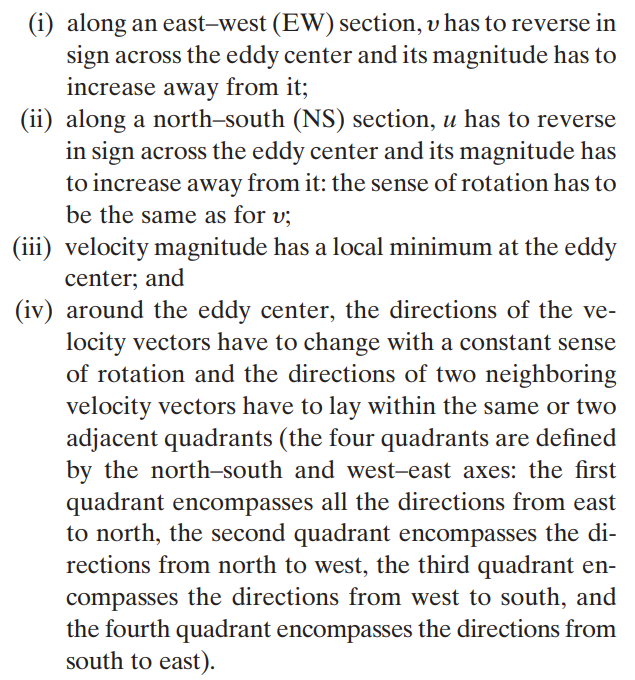

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [13]:
from scipy.io import netcdf_file
import os
# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file(os.path.join(os.path.abspath('') ,"04032019.nc"))
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_u = f.variables['ugos'].data.squeeze()
vel_v = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

#imputed_vel_u = interpolate_missing_point(vel_u, np.ma.masked_invalid(vel_u).mask)
#imputed_vel_v = interpolate_missing_point(vel_v, np.ma.masked_invalid(vel_v).mask)
imputed_vel_u = np.nan_to_num(vel_u, nan=1e30)[26:45,50:70]
imputed_vel_v = np.nan_to_num(vel_v, nan=1e30)[26:45,50:70]
lat = lat[26:45]
long = long[50:70]

/home/jakeb/development/mdm-phase-a-data/venv/lib/python3.9/site-packages/scipy/io/_netcdf.py:304: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


## Method Parameters:

In [3]:
a = 1
b = 1

## Constaint 3 

<IPython.core.display.Javascript object>


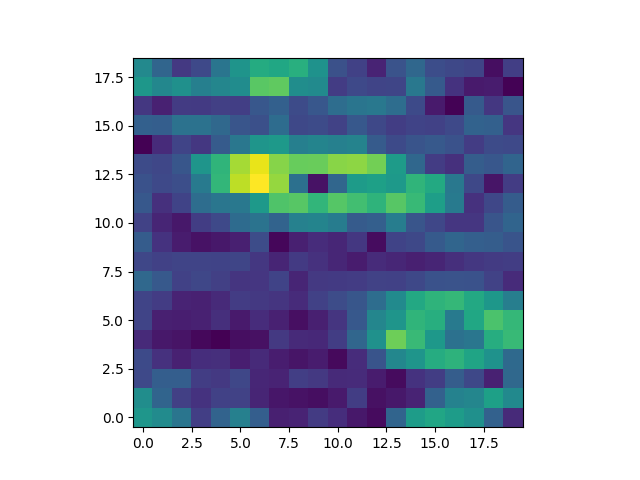

<IPython.core.display.Javascript object>


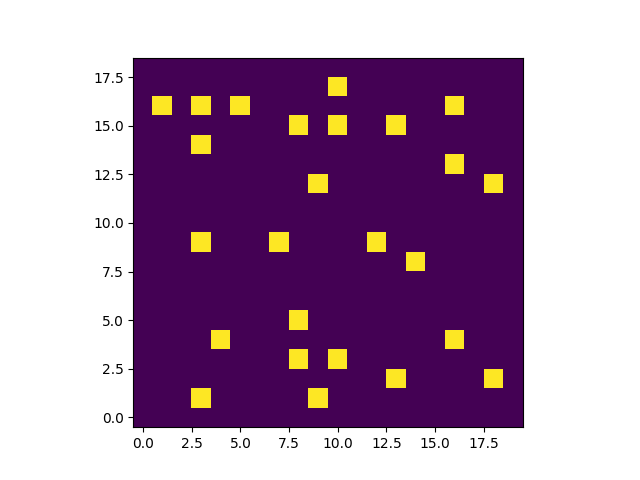

25


In [4]:
from skimage.feature import peak_local_max

vel_magnitude = np.hypot(imputed_vel_u, imputed_vel_v)
plt.figure()
plt.imshow(vel_magnitude, origin="lower")

satifies_crit_3 = peak_local_max(-vel_magnitude, min_distance=b)

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_3))] = 1
plt.imshow(tmp, origin="lower")
print(len(satifies_crit_3))

## Constraint 1

<IPython.core.display.Javascript object>


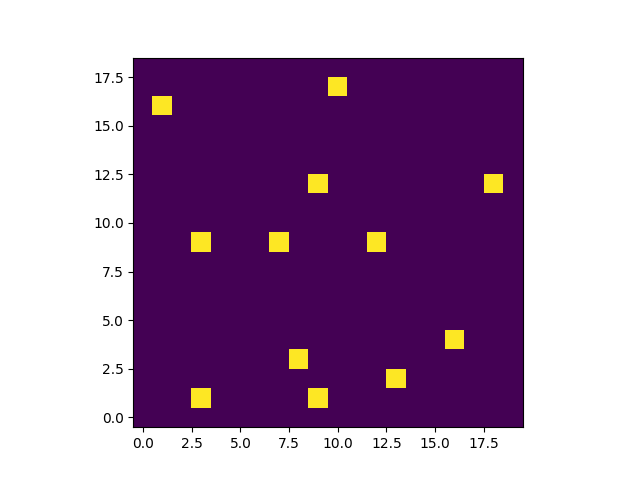

12


In [5]:
satifies_crit_1 = []
direction = []

for i,j in satifies_crit_3:
    center = imputed_vel_v[i,j]
    try:
        left = imputed_vel_v[i,j-a]
        right = imputed_vel_v[i,j+a]
    except IndexError:
        continue # point too close to the edge
    if abs(center) < abs(right) and abs(center) < abs(left) and np.sign(left)*np.sign(right) == -1:
        satifies_crit_1.append((i,j))
        direction.append(np.sign(left))

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_1))] = 1
plt.imshow(tmp, origin="lower")
print(len(satifies_crit_1))

## Constraint 2

i=9,j=7, center=-0.0014, bottom=0.0393, top=-0.11720000000000001
i=2,j=13, center=-0.015000000000000001, bottom=-0.0043, top=-0.09240000000000001
i=9,j=12, center=0.017, bottom=0.010700000000000001, top=-0.0645
i=1,j=9, center=-0.0135, bottom=-0.030500000000000003, top=0.054200000000000005
i=12,j=9, center=-0.012700000000000001, bottom=-0.23290000000000002, top=0.27290000000000003
i=9,j=3, center=-0.020800000000000003, bottom=0.0761, top=-0.0649
i=3,j=8, center=0.0176, bottom=0.050300000000000004, top=-0.041100000000000005
i=12,j=18, center=-0.024900000000000002, bottom=-0.0424, top=-0.0857
i=16,j=1, center=-0.020800000000000003, bottom=-0.1061, top=0.13470000000000001
i=1,j=3, center=0.044700000000000004, bottom=0.06380000000000001, top=0.06910000000000001
i=17,j=10, center=-0.009300000000000001, bottom=-0.1303, top=0.066
i=4,j=16, center=-0.12390000000000001, bottom=-0.22660000000000002, top=0.14800000000000002


<IPython.core.display.Javascript object>


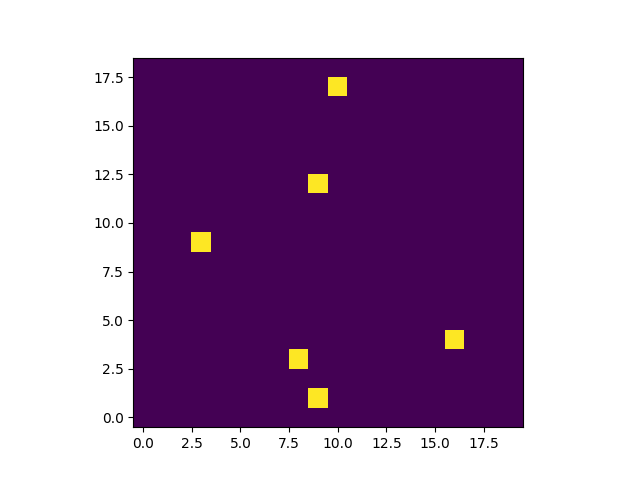

6


In [6]:
satifies_crit_2 = []

for (i, j), clockwise in zip(satifies_crit_1, direction):
    center = imputed_vel_u[i,j]
    try:
        bottom = imputed_vel_u[i-a, j]
        top = imputed_vel_u[i+a,j]
    except IndexError:
        continue # point to close to the edge
    print(f"{i=},{j=}, {center=}, {bottom=}, {top=}")
    if abs(center) < abs(bottom) and abs(center) < abs(top) and np.sign(bottom)*np.sign(top) == -1 and clockwise == np.sign(top):
        satifies_crit_2.append((i,j))

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_2))] = 1
plt.imshow(tmp, origin="lower")
print(len(satifies_crit_2))

## Constraint 4

In [7]:
satifies_crit_4 = []

get_edge = lambda arr: [arr[0,:-1], arr[:-1,-1], arr[-1,::-1], arr[-2:0:-1,0]]

extra_check = True

for i,j in satifies_crit_2:
    delta = a - 1
    try:
        area_u = imputed_vel_u[i-delta:i+delta,j-delta:j+delta]
        area_v = imputed_vel_v[i-delta:i+delta,j-delta:j+delta]
    except:
        continue
    edge_u = get_edge(area_u)
    edge_v = get_edge(area_v)
    
    if extra_check and not (np.unique(np.sign(edge_u[0])).size == 1 and 
        np.unique(np.sign(edge_u[2])).size == 1 and
        np.unique(np.sign(edge_v[1])).size == 1 and
        np.unique(np.sign(edge_v[3])).size == 1):
        continue
    
    edge_u = np.concatenate(edge_u)
    edge_v = np.concatenate(edge_v)
    v_angle = np.arctan2(edge_v, edge_u)
    v_angle[v_angle < 0] += 2*np.pi
    quadrant = np.zeros_like(v_angle)
    quadrant[(np.pi/2 <= v_angle) & (v_angle < np.pi)] = 1
    quadrant[(np.pi <= v_angle) & (v_angle < (3/2)*np.pi)] = 2
    quadrant[((3/2)*np.pi <= v_angle) & (v_angle < 2*np.pi)] = 3
    no_jumps = True
    for idx, q in enumerate(quadrant):
        if q == 0 and quadrant[(idx + 1) % len(quadrant)] in [0, 1, 3]:
            continue
        elif q == 1 and quadrant[(idx + 1) % len(quadrant)] in [1 , 0, 2]:
            continue
        elif q == 2 and quadrant[(idx + 1) % len(quadrant)] in [2, 1, 3]:
            continue
        elif q == 3 and quadrant[(idx + 1) % len(quadrant)] in [3 , 2, 0]:
            continue
        else:
            no_jumps = False
    satifies_crit_4.append((i,j))
print(len(satifies_crit_4))


IndexError: index 0 is out of bounds for axis 0 with size 0

## Plot the final thing

In [8]:
print(satifies_crit_2)

[(1, 9), (12, 9), (9, 3), (3, 8), (17, 10), (4, 16)]


<IPython.core.display.Javascript object>


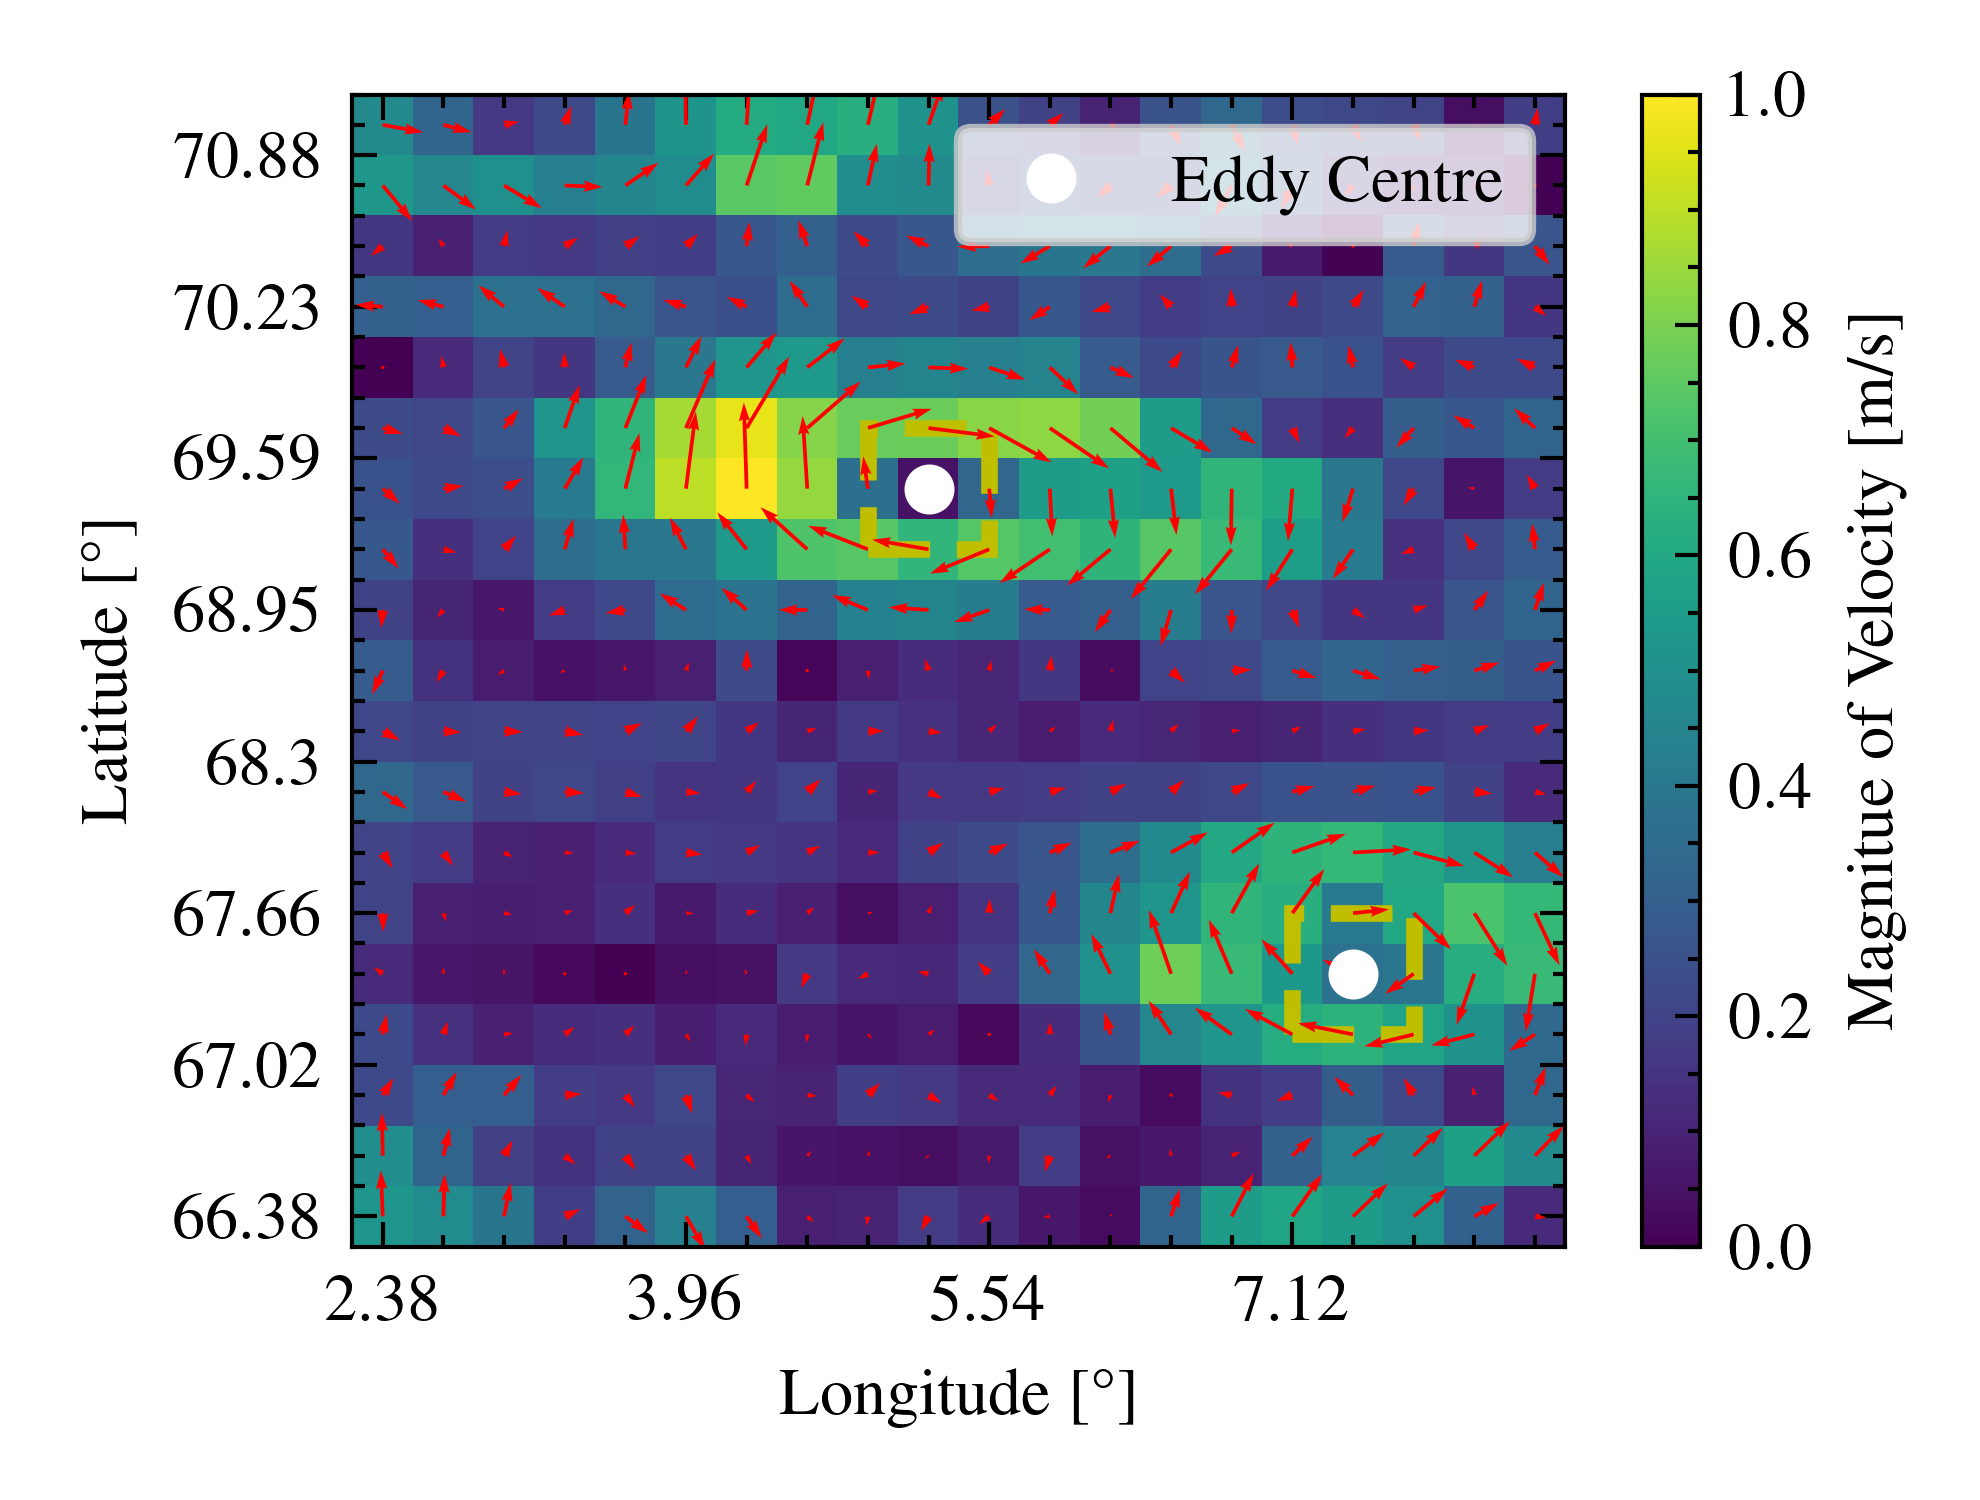

In [15]:
plt.style.use(['science','ieee'])

from matplotlib.patches import Rectangle

eddies = np.asarray(satifies_crit_2)

# start with magnitude of velocity as background
plt.figure()
plt.imshow(vel_magnitude, origin='lower')
plt.quiver(imputed_vel_u, imputed_vel_v, color='r', scale=5, zorder=2)
plt.plot(eddies[1,1], eddies[1,0],'w.', markersize=10, label="Eddy Centre")
plt.plot(eddies[-1,1], eddies[-1,0],'w.', markersize=10)
plt.gca().add_patch(Rectangle(eddies[1,:] - (4,-2), 2, 2 , linewidth=2,edgecolor='y',facecolor='none', linestyle='--'))
plt.gca().add_patch(Rectangle((15,3), 2, 2 , linewidth=2,edgecolor='y',facecolor='none', linestyle='--'))
plt.legend(loc='upper right', frameon=True)
cbar = plt.colorbar()
cbar.set_label("Magnitue of Velocity [m/s]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))
plt.tight_layout()
plt.savefig("figures/vectorgeom.pdf")